# ML Classification Into SQL
- Build Classification Model
- Extract features and build SQL Code Implementation
- SQL Code Logistic Regression Implementation:

# Key Features:
### Data Loading and Preprocessing:

- The script loads a heart-related dataset from a CSV file, handles missing values, and encodes categorical variables.
- Robust scaling is applied to continuous features.

### Model Training and Evaluation:

- Several classification models (e.g., AdaBoost, Logistic Regression, Random Forest, Gradient Boosting) are trained and evaluated.
- Model evaluation includes accuracy, confusion matrix, and ROC AUC. Cross-validation is implemented for more robust performance assessment.

### Hyperparameter Tuning:

- Hyperparameter tuning is performed for RandomForestClassifier and LogisticRegression using GridSearchCV.

### Feature Importance (Tree-based Models):

- For tree-based models, feature importance is extracted and displayed.

### Model Saving:

- Trained models are saved using joblib for potential deployment.


In [1]:
try:
    import imblearn
except ImportError:
    print("imbalanced-learn not found. Installing...")
    !pip install imbalanced-learn
    print("imbalanced-learn installed successfully!")

# Now import and use imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Importing necessary packages
import os
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv

from sklearn.calibration import calibration_curve
from scikitplot.metrics import plot_precision_recall
from sklearn.metrics import precision_recall_curve, auc
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

import xgboost as xgb
import sqlite3


# Setting up options and ignoring warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'classification_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

In [3]:
# Reading the dataset
dataset_path = "/kaggle/input/heart.csv"

# Reading the dataset
#dataset_path = "../input/heart-attack-analysis-prediction-dataset/heart.csv"
#/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv

try:
    # Attempt to read the dataset
    df = pd.read_csv(dataset_path)
    logger.info(f"Dataset loaded successfully from {dataset_path}")
except FileNotFoundError:
    logger.error("Error: Dataset file not found. Please provide the correct file path.")
except Exception as e:
    logger.error(f"An error occurred: {e}")
    
df.head(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.300000,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500000,0,0,2,1


In [4]:
# creating a copy of df
df1 = df.fillna(0)

# define the columns to be encoded and scaled
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]

#target column name
label_name = 'output'

# encoding the categorical columns
df1 = pd.get_dummies(df1, columns = cat_cols, drop_first = True)

# defining the features and target
X = df1.drop([label_name],axis=1)
y = df1[[label_name]]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[con_cols] = scaler.fit_transform(X[con_cols])

# Get centering and scaling values for each feature
centering = scaler.center_
iqrs  = scaler.scale_

X.head()

,age,trtbps,chol,thalachh,oldpeak,sex_1,exng_1,caa_1,caa_2,caa_3,caa_4,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,slp_1,slp_2,thall_1,thall_2,thall_3
0,0.592593,0.750000,-0.110236,-0.092308,0.937500,True,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False
1,-1.333333,0.000000,0.157480,1.046154,1.687500,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False
2,-1.037037,0.000000,-0.566929,0.584615,0.375000,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False
3,0.074074,-0.500000,-0.062992,0.769231,0.000000,True,False,False,False,False,False,True,False,False,False,True,False,False,True,False,True,False
4,0.148148,-0.500000,1.795276,0.307692,-0.125000,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False


In [5]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)

The shape of X_train is       (242, 22)
The shape of X_test is        (61, 22)
The shape of y_train is       (242, 1)
The shape of y_test is        (61, 1)


In [6]:
# Handling Class Imbalance with RandomOverSampler
ros = RandomOverSampler(sampling_strategy=0.9, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [7]:
print("The shape of X_train is      ", X_resampled.shape)
print("The shape of y_train is      ", y_resampled.shape)

The shape of X_train is       (252, 22)
The shape of y_train is       (252, 1)


### For binary classification:
- accuracy: Calculates the accuracy of the classifier.
- precision': Measures the ability of the classifier not to label as positive a sample that is negative.
- recall: Measures the ability of the classifier to capture all the positive samples.
- f1: Combines precision and recall into a single metric.
- roc_auc: Computes the area under the Receiver Operating Characteristic (ROC) curve.

## Hyperparameter Tuning RandomForest

In [8]:
%%time

# instantiating the object
model = RandomForestClassifier()

# setting a grid - not so extensive
parameters = {'n_estimators': [10],
    'max_depth': [24],
    'min_samples_split': [2],
    'min_samples_leaf': [7],
    'verbose': [0],  # Verbosity
    'criterion': ['gini','entropy'],
    'max_features': ['auto'],
    'bootstrap':[True],
    'class_weight':['balanced'],
    'warm_start': [True],  # Warm start
    'random_state': [42],  # Random state for reproducibility         
    'oob_score':[True],
    'n_jobs': [-1]}

searcher = GridSearchCV(estimator = model, param_grid = parameters,cv=2, scoring='roc_auc',verbose=2, n_jobs=-1)

# fitting the object
searcher.fit(X_train, y_train)

# the scores
print("The best params are :", searcher.best_params_)
print("The best score is   :", searcher.best_score_)

# predicting the values
y_pred = searcher.predict(X_test)

# printing the test accuracy
print("The test accuracy score of model after hyper-parameter tuning is ", accuracy_score(y_test, y_pred))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expl

The best params are : {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 24, 'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': True}
The best score is   : 0.8449049518248976
The test accuracy score of model after hyper-parameter tuning is  0.819672131147541
CPU times: user 145 ms, sys: 77.1 ms, total: 222 ms
Wall time: 2.66 s


In [9]:
# Get the best hyperparameters from the GridSearchCV
best_params = searcher.best_params_
print(best_params)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 24, 'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': True}


In [10]:
model=RandomForestClassifier(**best_params)
model.fit(X_resampled, y_resampled.values.ravel())
predict = model.predict(X_test)
acc = accuracy_score(y_test, predict)
conf = confusion_matrix(y_test, predict)

y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test,y_pred_proba)

print(acc)
print(conf)    
print(classification_report(y_test,predict))

0.8524590163934426
[[26  3]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.90      0.81      0.85        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



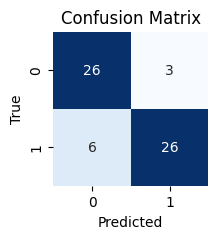

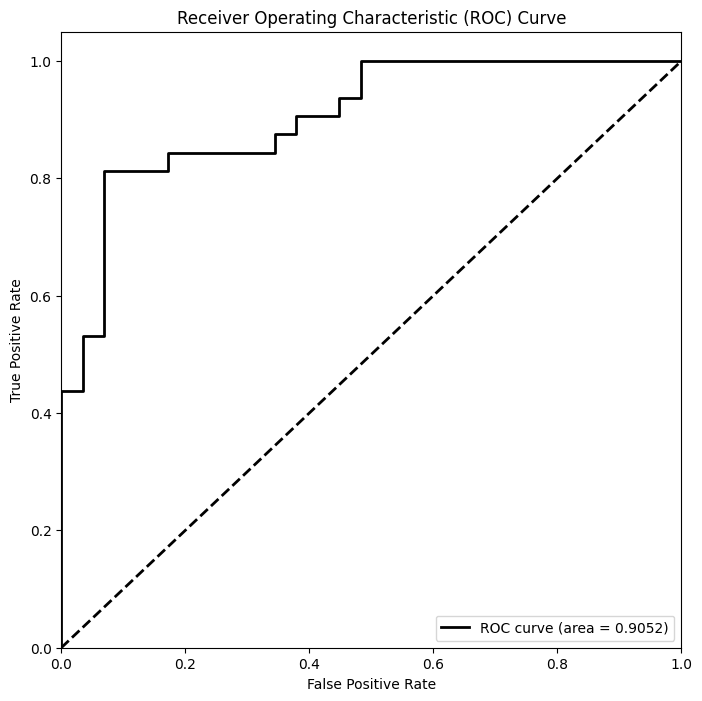

In [11]:
# Plot Confusion Matrix
plt.figure(figsize=(2,2))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='black', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

 - Feature Importance:
      Feature  Importance
4     oldpeak    0.198193
3    thalachh    0.135127
6      exng_1    0.132452
0         age    0.100844
21    thall_3    0.087496
20    thall_2    0.063019
18      slp_2    0.058416
1      trtbps    0.052846
2        chol    0.037018
17      slp_1    0.033666
7       caa_1    0.028745
8       caa_2    0.027785
5       sex_1    0.022911
12       cp_2    0.018628
11       cp_1    0.002853
15  restecg_1    0.000000
16  restecg_2    0.000000
14      fbs_1    0.000000
10      caa_4    0.000000
19    thall_1    0.000000
9       caa_3    0.000000
13       cp_3    0.000000


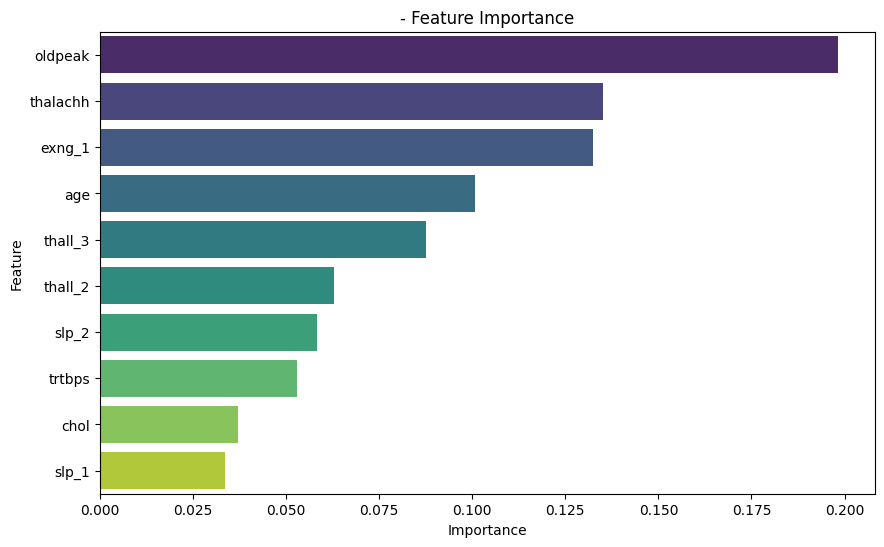

In [12]:
feature_importances = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
sorted_df = importance_df.sort_values(by='Importance', ascending=False)
sorted_df = sorted_df.head(10)

# Print sorted feature importance
print(f" - Feature Importance:")
print(importance_df.sort_values(by='Importance', ascending=False))

 # Create seaborn bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=sorted_df, palette='viridis')
plt.title(f"- Feature Importance")
plt.show()

In [13]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import joblib

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing pipeline with RobustScaler
preprocessor = Pipeline(steps=[('scaler', RobustScaler())])

# Define the Random Forest classifier
rf_clf = RandomForestClassifier()

# Define the hyperparameters grid
param_grid = {
    'classifier__n_estimators': [10],
    #'classifier__criterion': ['gini', 'entropy'],
    #'classifier__max_depth': [None, 10, 20],
    #'classifier__min_samples_split': [2, 5, 10],
    #'classifier__min_samples_leaf': [1, 2, 4],
    #'classifier__max_features': ['sqrt'],
    #'classifier__bootstrap': [True, False],
    #'classifier__class_weight': [None, 'balanced', 'balanced_subsample'],
    #'classifier__random_state': [42],
    #'classifier__warm_start': [True, False],
    'classifier__oob_score': [True, False]
}

# Define GridSearchCV with preprocessing pipeline
grid_search = GridSearchCV(estimator=Pipeline([('preprocessor', preprocessor), ('classifier', rf_clf)]),
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Save the model to disk
saved_model_path = 'saved_model.pkl'
joblib.dump(grid_search.best_estimator_, saved_model_path)

# Load the saved model
loaded_model = joblib.load(saved_model_path)

# Load the new data
new_data = np.array([[6.1, 2.8, 4.7, 1.2], [5.5, 2.6, 4.4, 1.5], [7.3, 2.9, 6.3, 1.8]])

# Preprocess the new data using the saved preprocessing pipeline
preprocessed_data = loaded_model.named_steps['preprocessor'].transform(new_data)

# Make predictions using the loaded model
predictions = loaded_model.predict(preprocessed_data)

# Get probability scores for each class
probability_scores = loaded_model.predict_proba(preprocessed_data)

# Print or use the predictions and probability scores as needed
print("Predictions for new data:")
print(predictions)
print("Probability scores for each class:")
print(probability_scores)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Predictions for new data:
[0 0 0]
Probability scores for each class:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [14]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import joblib

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing pipeline with RobustScaler
preprocessor = Pipeline(steps=[('scaler', RobustScaler())])

# Define the Random Forest classifier
rf_clf = RandomForestClassifier()

# Define the hyperparameters grid
param_grid = {
    'classifier__n_estimators': [10],
    #'classifier__max_depth': [None, 10, 20],
    #'classifier__min_samples_split': [2, 5, 10],
    #'classifier__min_samples_leaf': [1, 2, 4],
    #'classifier__max_features': ['auto', 'sqrt', 'log2'],
    #'classifier__bootstrap': [True, False],
    #'classifier__class_weight': [None, 'balanced', 'balanced_subsample'],
    #'classifier__random_state': [42],
    #'classifier__warm_start': [True, False],
    'classifier__oob_score': [True, False]
}

# Define Stratified KFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define GridSearchCV with preprocessing pipeline
grid_search = GridSearchCV(estimator=Pipeline([('preprocessor', preprocessor), ('classifier', rf_clf)]),
                           param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Log best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Accuracy):", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Save the best model to disk
saved_model_path = 'saved_model.pkl'
joblib.dump(best_model, saved_model_path)

# Load the saved model
loaded_model = joblib.load(saved_model_path)

# Load the new data
new_data = np.array([[6.1, 2.8, 4.7, 1.2], [5.5, 2.6, 4.4, 1.5], [7.3, 2.9, 6.3, 1.8]])

# Preprocess the new data using the saved preprocessing pipeline
preprocessed_data = loaded_model.named_steps['preprocessor'].transform(new_data)

# Make predictions using the loaded model
predictions = loaded_model.predict(preprocessed_data)

# Get probability scores for each class
probability_scores = loaded_model.predict_proba(preprocessed_data)

# Print or use the predictions and probability scores as needed
print("Predictions for new data:")
print(predictions)
print("Probability scores for each class:")
print(probability_scores)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'classifier__n_estimators': 10, 'classifier__oob_score': True}
Best Score (Accuracy): 0.9333333333333333
Test Accuracy: 1.0
Predictions for new data:
[0 0 0]
Probability scores for each class:
[[0.9 0.  0.1]
 [0.9 0.  0.1]
 [0.9 0.  0.1]]


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
